In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Conv2D, MaxPooling2D,Flatten, Reshape, Dropout, BatchNormalization,LeakyReLU, Conv2DTranspose, ReLU

from matplotlib import pyplot as plt
import numpy as np

import os

In [2]:
batch_size = 128
path = "Only_cloth_or_cloth_with_person"
train_images = tf.keras.utils.image_dataset_from_directory(
    path, label_mode=None, image_size=(64, 64), batch_size=32
)

Found 667 files belonging to 1 classes.


2022-10-30 22:28:42.729331: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


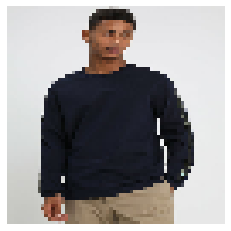

In [14]:
image_batch = next(iter(train_images))
random_index = np.random.choice(image_batch.shape[0])
random_image = image_batch[random_index].numpy().astype("int32")
plt.axis("off")
plt.imshow(random_image)
plt.show()

In [6]:
# Normalize the images to [-1, 1] which is the range of the tanh activation
train_images = train_images.map(lambda x: (x - 127.5) / 127.5)

In [58]:
# latent dimension of the random noise
LATENT_DIM = 3 
# weight initializer for G per DCGAN paper
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02) 
# number of channels, 1 for gray scale and 3 for color images
CHANNELS = 3 # UPDATED from 1

In [59]:
def build_generator():
    # create a Keras Sequential model 
    model = Sequential(name='generator')

    # prepare for reshape: FC => BN => RN layers, note: input shape defined in the 1st Dense layer  
    model.add(layers.Dense(8 * 8 * 512, input_dim=LATENT_DIM))
    # model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    # layers.LeakyReLU(alpha=0.2),

    # 1D => 3D: reshape the output of the previous layer 
    model.add(layers.Reshape((8, 8, 512)))

    # upsample to 16x16: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    # model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # upsample to 32x32: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    # model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # upsample to 64x64: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    # model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # final layer: Conv2D with tanh activation
    model.add(layers.Conv2D(CHANNELS, (4, 4), padding="same", activation="tanh"))

    # return the generator model
    return model
# build the generator model
generator = build_generator()

In [60]:
def build_discriminator(height, width, depth, alpha=0.2):
    # create a Keras Sequential model
    model = Sequential(name='discriminator')
    input_shape = (height, width, depth)

    # 1. first set of CONV => BN => leaky ReLU layers
    model.add(layers.Conv2D(64, (4, 4), padding="same", strides=(2, 2),
        input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # 2. second set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (4, 4), padding="same", strides=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # 3. third set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (4, 4), padding="same", strides=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # flatten and apply dropout
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))

    # sigmoid in the last layer outputting a single value for binary classification
    model.add(layers.Dense(1, activation="sigmoid"))

    # return the discriminator model
    return model
# build the discriminator model
discriminator = build_discriminator(64, 64, 3)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_4 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 128)     

In [61]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim), mean=0.0, stddev=4.0)

        # Step 1. Train the discriminator with both real images (label as 1) and fake images (classified as label as 0) 
        with tf.GradientTape() as tape:
            # Compute discriminator loss on real images
            pred_real = self.discriminator(real_images, training=True)
            real_labels = tf.ones((batch_size, 1))
            # UPDATED: apply one-sided label smoothing to real labels
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels)) 
            d_loss_real = self.loss_fn(real_labels, pred_real)

            # Compute discriminator loss on fake images
            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images, training=True)
            fake_labels = tf.zeros((batch_size, 1))
            # UPDATED: add random noise to fake labels - not needed
            # fake_labels += 0.05 * tf.random.uniform(tf.shape(fake_labels)) 
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)
            print(d_loss_fake)
            print(d_loss_real)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake)/2
        # Compute discriminator gradients
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Update discriminator weights
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Step 2. Train the generator (do not update weights of the discriminator)
        misleading_labels = tf.ones((batch_size, 1)) # G wants D to think the fake images are real (label as 1)

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)
        # Compute generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator wieghts
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [62]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

        # Create random noise seed for visualization during traing
        self.seed = tf.random.normal([16, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(4, 4))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(generated_images[i]) 
            plt.imshow(img)
            plt.axis('off')
        plt.savefig('epoch_{:03d}.png'.format(epoch)) 
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

In [63]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)

In [64]:
D_LR = 0.0001 # UPDATED: discriminator learning rate
G_LR = 0.0003 # UPDATED: generator learning rate

dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=D_LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=G_LR, beta_1 = 0.5),  
    loss_fn=keras.losses.BinaryCrossentropy(),
)

Epoch 1/50
Tensor("binary_crossentropy_1/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy_1/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.4447 - g_loss: 3.0819

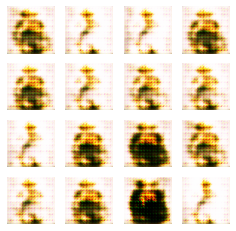

1012/1012 [==============================] - 38s 36ms/step - d_loss: 0.4452 - g_loss: 3.0796
Epoch 2/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.4331 - g_loss: 1.9325

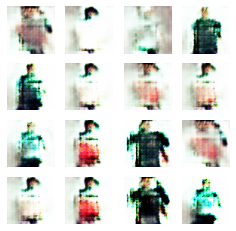

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.4330 - g_loss: 1.9324
Epoch 3/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.4418 - g_loss: 1.8200

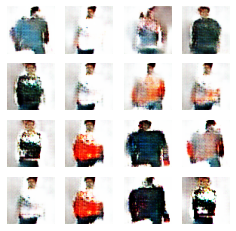

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.4419 - g_loss: 1.8192
Epoch 4/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.4808 - g_loss: 1.6167

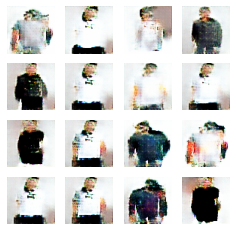

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.4807 - g_loss: 1.6177
Epoch 5/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.5188 - g_loss: 1.4591

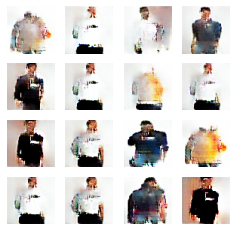

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.5189 - g_loss: 1.4590
Epoch 6/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.5721 - g_loss: 1.2932

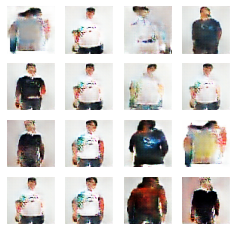

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.5725 - g_loss: 1.2926
Epoch 7/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.5832 - g_loss: 1.2338

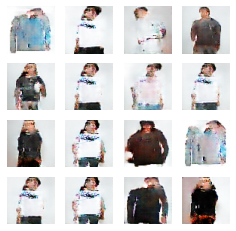

1012/1012 [==============================] - 37s 37ms/step - d_loss: 0.5830 - g_loss: 1.2333
Epoch 8/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.5850 - g_loss: 1.2172

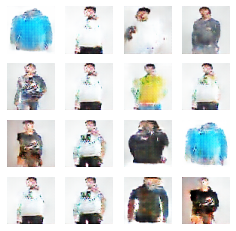

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.5849 - g_loss: 1.2176
Epoch 9/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.5795 - g_loss: 1.2343

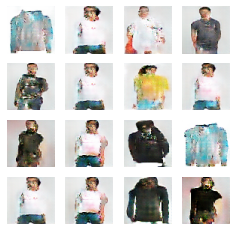

1012/1012 [==============================] - 37s 37ms/step - d_loss: 0.5793 - g_loss: 1.2341
Epoch 10/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.5870 - g_loss: 1.2069

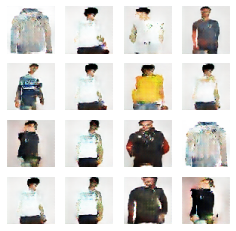

1012/1012 [==============================] - 37s 37ms/step - d_loss: 0.5871 - g_loss: 1.2068
Epoch 11/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.5881 - g_loss: 1.2024

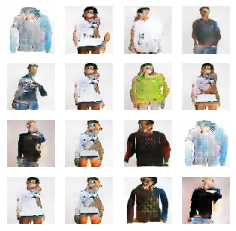

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.5881 - g_loss: 1.2025
Epoch 12/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.5677 - g_loss: 1.2338

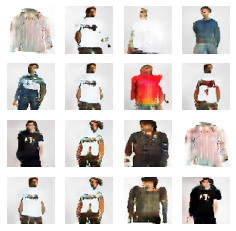

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.5674 - g_loss: 1.2342
Epoch 13/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.5588 - g_loss: 1.2640

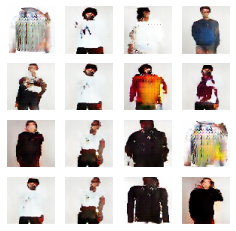

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.5587 - g_loss: 1.2643
Epoch 14/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.5552 - g_loss: 1.2754

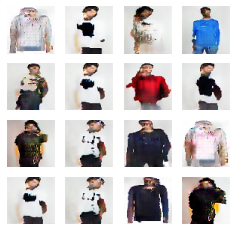

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.5552 - g_loss: 1.2753
Epoch 15/50
1010/1012 [============================>.] - ETA: 0s - d_loss: 0.5473 - g_loss: 1.2975

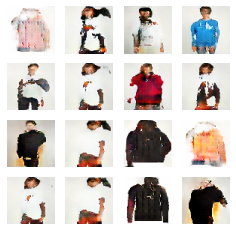

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.5473 - g_loss: 1.2978
Epoch 16/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.5230 - g_loss: 1.3710

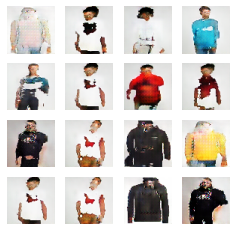

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.5232 - g_loss: 1.3716
Epoch 17/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.5249 - g_loss: 1.3754

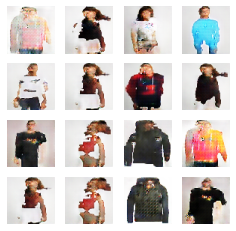

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.5253 - g_loss: 1.3749
Epoch 18/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.4995 - g_loss: 1.4386

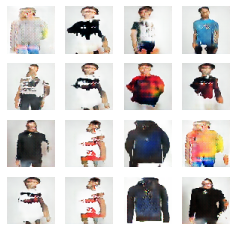

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.4997 - g_loss: 1.4397
Epoch 19/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.4921 - g_loss: 1.4917

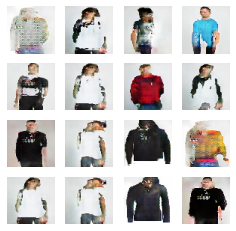

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.4922 - g_loss: 1.4928
Epoch 20/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.4644 - g_loss: 1.5723

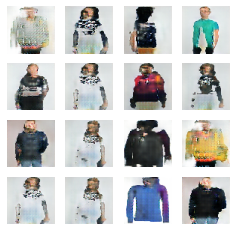

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.4648 - g_loss: 1.5714
Epoch 21/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.4580 - g_loss: 1.6057

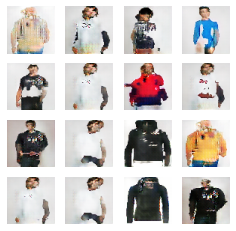

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.4581 - g_loss: 1.6052
Epoch 22/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.4542 - g_loss: 1.6450

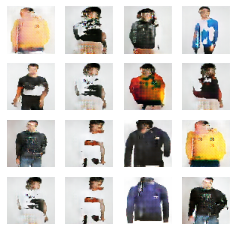

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.4541 - g_loss: 1.6446
Epoch 23/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.4411 - g_loss: 1.6684

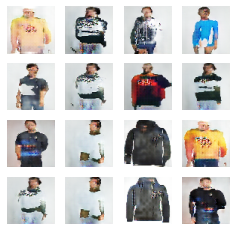

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.4415 - g_loss: 1.6676
Epoch 24/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.4313 - g_loss: 1.7314

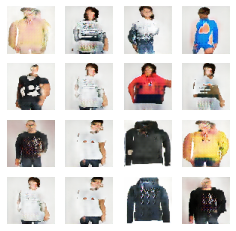

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.4311 - g_loss: 1.7314
Epoch 25/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.4361 - g_loss: 1.7489

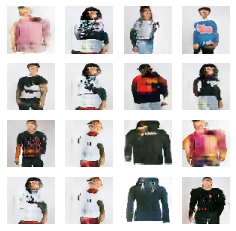

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.4362 - g_loss: 1.7511
Epoch 26/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.4059 - g_loss: 1.8496

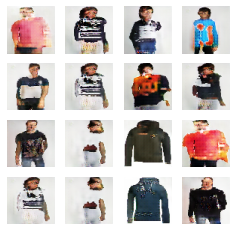

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.4062 - g_loss: 1.8487
Epoch 27/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.4104 - g_loss: 1.8806

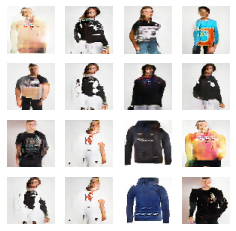

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.4109 - g_loss: 1.8789
Epoch 28/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.3955 - g_loss: 1.9221

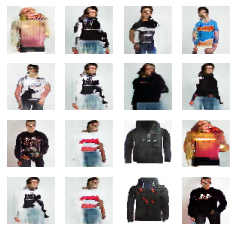

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.3954 - g_loss: 1.9217
Epoch 29/50
1010/1012 [============================>.] - ETA: 0s - d_loss: 0.3891 - g_loss: 1.9741

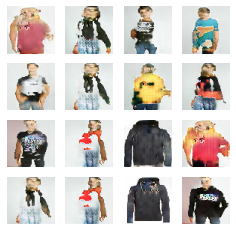

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.3893 - g_loss: 1.9736
Epoch 30/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.3764 - g_loss: 2.0605

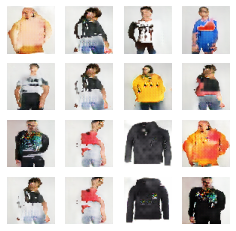

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.3765 - g_loss: 2.0598
Epoch 31/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.3669 - g_loss: 2.0904

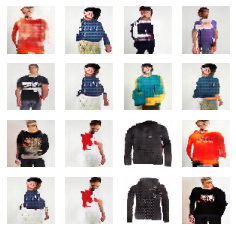

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.3672 - g_loss: 2.0902
Epoch 32/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.3443 - g_loss: 2.2166

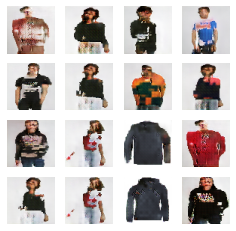

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.3441 - g_loss: 2.2162
Epoch 33/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.3297 - g_loss: 2.2902

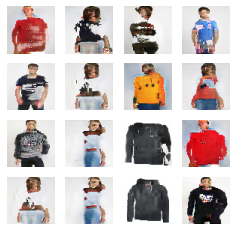

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.3299 - g_loss: 2.2904
Epoch 34/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.3402 - g_loss: 2.2327

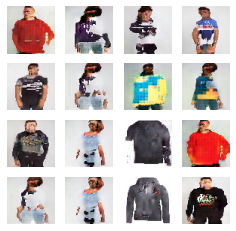

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.3401 - g_loss: 2.2332
Epoch 35/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.3373 - g_loss: 2.2808

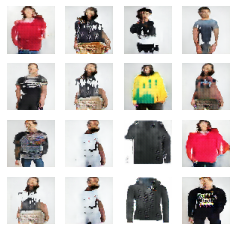

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.3373 - g_loss: 2.2809
Epoch 36/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.3201 - g_loss: 2.3596

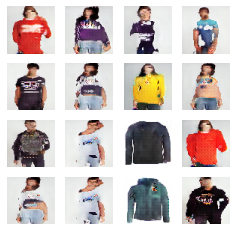

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.3206 - g_loss: 2.3586
Epoch 37/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.3148 - g_loss: 2.4046

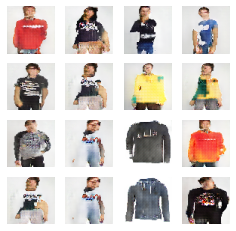

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.3148 - g_loss: 2.4035
Epoch 38/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.3009 - g_loss: 2.4963

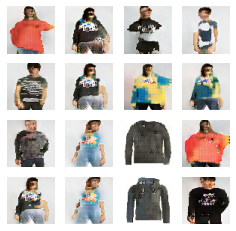

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.3009 - g_loss: 2.4981
Epoch 39/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.3066 - g_loss: 2.5421

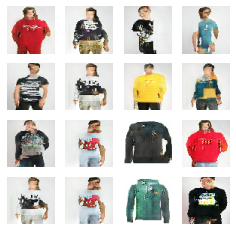

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.3065 - g_loss: 2.5436
Epoch 40/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.2997 - g_loss: 2.5673

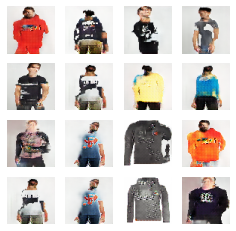

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.2997 - g_loss: 2.5664
Epoch 41/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.2912 - g_loss: 2.6337

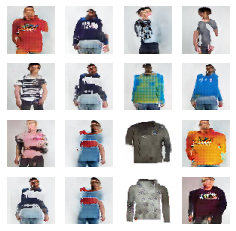

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.2914 - g_loss: 2.6325
Epoch 42/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.2867 - g_loss: 2.7002

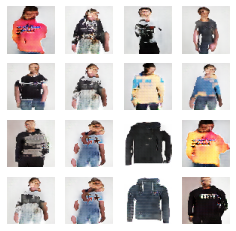

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.2869 - g_loss: 2.7000
Epoch 43/50
1010/1012 [============================>.] - ETA: 0s - d_loss: 0.2885 - g_loss: 2.6807

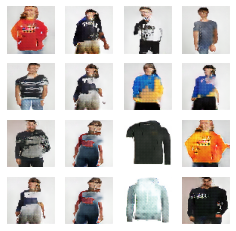

1012/1012 [==============================] - 37s 37ms/step - d_loss: 0.2888 - g_loss: 2.6815
Epoch 44/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.2855 - g_loss: 2.6966

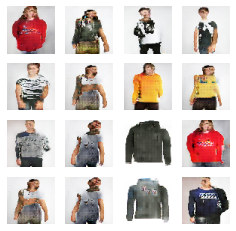

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.2855 - g_loss: 2.6985
Epoch 45/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.2893 - g_loss: 2.7422

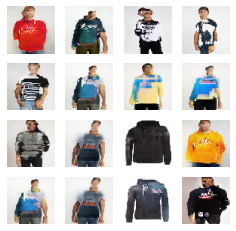

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.2893 - g_loss: 2.7417
Epoch 46/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.2823 - g_loss: 2.7476

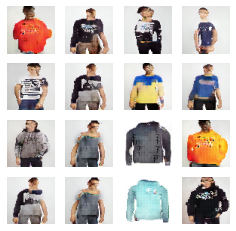

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.2822 - g_loss: 2.7476
Epoch 47/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.2697 - g_loss: 2.8263

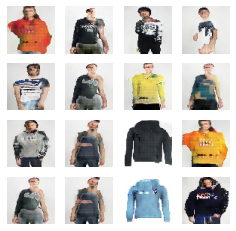

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.2699 - g_loss: 2.8251
Epoch 48/50
1010/1012 [============================>.] - ETA: 0s - d_loss: 0.2577 - g_loss: 2.8972

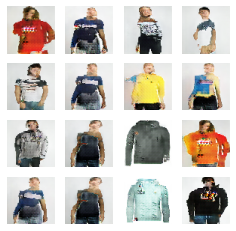

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.2575 - g_loss: 2.8973
Epoch 49/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.2520 - g_loss: 2.9662

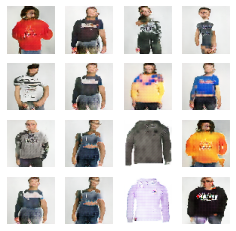

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.2520 - g_loss: 2.9653
Epoch 50/50
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.2445 - g_loss: 3.0407

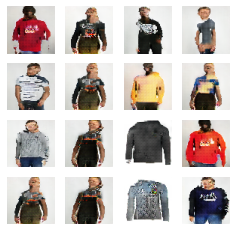

1012/1012 [==============================] - 37s 36ms/step - d_loss: 0.2444 - g_loss: 3.0427


In [65]:
NUM_EPOCHS = 50 # number of epochs
dcgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])

In [98]:
generator.save('generator_for_kaggle_cloth_3dim.h5')
discriminator.save('discriminator_for_kaggle_cloth_3dim.h5')

### All good so far.

# 2 using custom generator

In [78]:
# using orignal discriminator
def build_discriminator(height, width, depth, alpha=0.2):
    # create a Keras Sequential model
    model = Sequential(name='discriminator')
    input_shape = (height, width, depth)

    # 1. first set of CONV => BN => leaky ReLU layers
    model.add(layers.Conv2D(64, (4, 4), padding="same", strides=(2, 2),
        input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # 2. second set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (4, 4), padding="same", strides=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # 3. third set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (4, 4), padding="same", strides=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # flatten and apply dropout
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))

    # sigmoid in the last layer outputting a single value for binary classification
    model.add(layers.Dense(1, activation="sigmoid"))

    # return the discriminator model
    return model

discriminator = build_discriminator(64,64,3)


Generator = Sequential([   ###good generator
    Dense(8*8*512, input_shape = (100,)),   ### upsampel to 8*8*512(32768)    instead of 4*4*1024(16384)
    ReLU(),
    Reshape((8,8,512)),
    
    Conv2DTranspose(256 ,(4,4), strides = (2,2), padding = 'same'),
    ReLU(),
    
    Conv2DTranspose(128 ,(4,4), strides = (2,2), padding = 'same'),
    ReLU(),
    
    Conv2DTranspose(3 ,(4,4), strides = (2,2), padding = 'same', activation = 'tanh'),
])


# using my generator 
generator = Sequential([
    Dense(8*8*512, use_bias = False, input_shape = (100,)),
    BatchNormalization(),
    LeakyReLU(),
    Reshape((8,8,512)),
    
    Conv2DTranspose(256 ,(4,4), strides = (2,2), use_bias = False, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(),
    
    Conv2DTranspose(128 ,(4,4), strides = (2,2), use_bias = False, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(),
    
    Conv2DTranspose(3 ,(4,4), strides = (2,2), use_bias = False, padding = 'same', activation = 'tanh'),
])


## Difference: 1, upsample to 4*4*1024 instad of 8*8*512

## change1 : change upsample into 8*8*512  inorder to meet 64*64*3 also delete a layer of conv2DTranspose: increased a bit
## change2 : change kernel size into (4*4): huge increase in profermence 
######  maybe kernel size match the discriminator?

## change3 : revise to 4*4*1024 but chage kernel size into 4*4

#

Epoch 1/5
Tensor("binary_crossentropy_1/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy_1/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
1011/1012 [============================>.] - ETA: 0s - d_loss: 6.0502 - g_loss: 10.1744

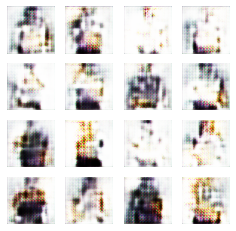

1012/1012 [==============================] - 99s 95ms/step - d_loss: 6.0446 - g_loss: 10.1653
Epoch 2/5
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.7713 - g_loss: 1.0359

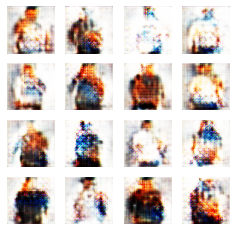

1012/1012 [==============================] - 98s 97ms/step - d_loss: 0.7714 - g_loss: 1.0356
Epoch 3/5
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.5595 - g_loss: 0.7577

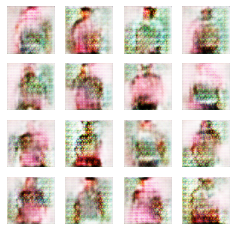

1012/1012 [==============================] - 99s 97ms/step - d_loss: 0.5585 - g_loss: 0.7570
Epoch 4/5
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.9050 - g_loss: 1.0245

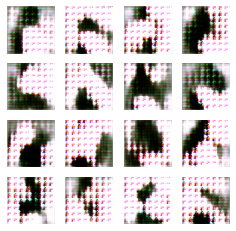

1012/1012 [==============================] - 98s 97ms/step - d_loss: 0.9050 - g_loss: 1.0338
Epoch 5/5
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.4412 - g_loss: 0.9005

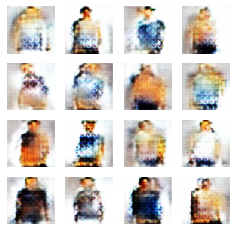

1012/1012 [==============================] - 99s 98ms/step - d_loss: 0.4412 - g_loss: 0.9001


In [77]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)
D_LR = 0.0001 # UPDATED: discriminator learning rate
G_LR = 0.0005 # UPDATED: generator learning rate

dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=D_LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=G_LR, beta_1 = 0.5),  
    loss_fn=keras.losses.BinaryCrossentropy(),
)
NUM_EPOCHS = 5 # number of epochs
dcgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])

### 8 * 8 * 512 upsample and (4,4) kernel size for generator is the most important config

In [84]:
# using good generator

generator = Sequential([
    Dense(8*8*512, use_bias = False, input_shape = (100,)),
    BatchNormalization(),
    LeakyReLU(),
    Reshape((8,8,512)),
    
    Conv2DTranspose(256 ,(4,4), strides = (2,2), use_bias = False, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(),
    
    Conv2DTranspose(128 ,(4,4), strides = (2,2), use_bias = False, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(),
    
    Conv2DTranspose(3 ,(4,4), strides = (2,2), use_bias = False, padding = 'same', activation = 'tanh'),
])


def build_discriminator(height, width, depth, alpha=0.2):
    # create a Keras Sequential model
    model = Sequential(name='discriminator')
    input_shape = (height, width, depth)

    # 1. first set of CONV => BN => leaky ReLU layers
    model.add(layers.Conv2D(64, (4, 4), padding="same", strides=(2, 2),
        input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # 2. second set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (4, 4), padding="same", strides=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # 3. third set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (4, 4), padding="same", strides=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # flatten and apply dropout
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))

    # sigmoid in the last layer outputting a single value for binary classification
    model.add(layers.Dense(1, activation="sigmoid"))

    # return the discriminator model
    return model



discriminator = Sequential([
    Conv2D(128, (5,5), strides = (2,2), padding = 'same', input_shape = (64,64,3)), # input_shape = (64,64,3)
    LeakyReLU(),
    Dropout(0.2),
    
    Conv2D(256, (5,5), strides = (2,2), padding = 'same'),
    LeakyReLU(),
    Dropout(0.2),
    
    Conv2D(512, (5,5), strides = (2,2), padding = 'same'),
    LeakyReLU(),
    Dropout(0.2),
    
    Flatten(),
    Dense(1, activation = 'sigmoid')
])


### differences:1, kernel size 4,4 instead of 5,5.  2, not using BN layer.  3, miner things

Epoch 1/10
Tensor("binary_crossentropy_1/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy_1/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.7531 - g_loss: 0.6264

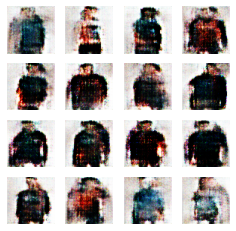

1012/1012 [==============================] - 33s 31ms/step - d_loss: 0.7529 - g_loss: 0.6269
Epoch 2/10
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.6545 - g_loss: 0.7037

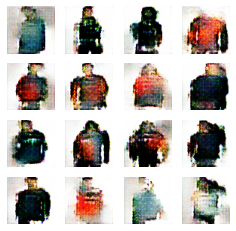

1012/1012 [==============================] - 31s 30ms/step - d_loss: 0.6546 - g_loss: 0.7043
Epoch 3/10
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.4175 - g_loss: 0.5611

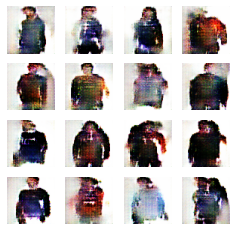

1012/1012 [==============================] - 31s 30ms/step - d_loss: 0.4177 - g_loss: 0.5627
Epoch 4/10
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.3198 - g_loss: 0.5553

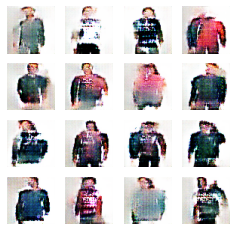

1012/1012 [==============================] - 31s 30ms/step - d_loss: 0.3198 - g_loss: 0.5558
Epoch 5/10
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.3338 - g_loss: 0.6444

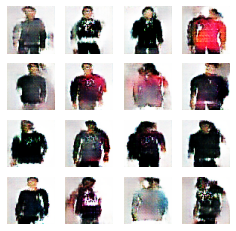

1012/1012 [==============================] - 32s 32ms/step - d_loss: 0.3339 - g_loss: 0.6443
Epoch 6/10
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.4631 - g_loss: 1.0223

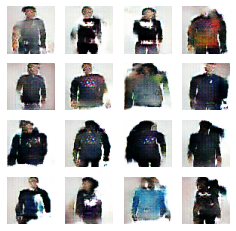

1012/1012 [==============================] - 33s 32ms/step - d_loss: 0.4635 - g_loss: 1.0226
Epoch 7/10
1010/1012 [============================>.] - ETA: 0s - d_loss: 0.4799 - g_loss: 1.2146

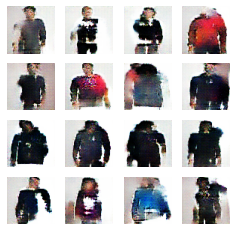

1012/1012 [==============================] - 33s 32ms/step - d_loss: 0.4794 - g_loss: 1.2140
Epoch 8/10
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.4766 - g_loss: 1.3303

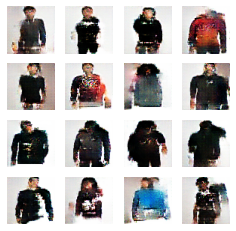

1012/1012 [==============================] - 33s 33ms/step - d_loss: 0.4763 - g_loss: 1.3306
Epoch 9/10
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.4588 - g_loss: 1.4185

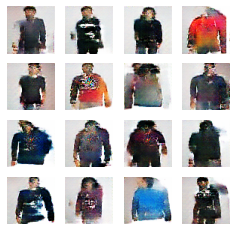

1012/1012 [==============================] - 33s 32ms/step - d_loss: 0.4587 - g_loss: 1.4183
Epoch 10/10
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.4364 - g_loss: 1.5051

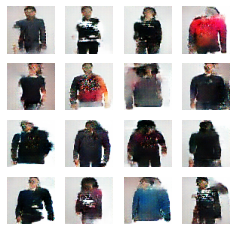

1012/1012 [==============================] - 33s 32ms/step - d_loss: 0.4362 - g_loss: 1.5047


In [85]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)
D_LR = 0.0001 # UPDATED: discriminator learning rate
G_LR = 0.0005 # UPDATED: generator learning rate

dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=D_LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=G_LR, beta_1 = 0.5),  
    loss_fn=keras.losses.BinaryCrossentropy(),
)
NUM_EPOCHS = 10 # number of epochs
dcgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])

Epoch 1/10
Tensor("binary_crossentropy_1/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy_1/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.6150 - g_loss: 1.0142

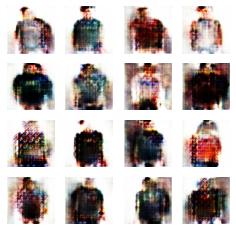

1012/1012 [==============================] - 60s 57ms/step - d_loss: 0.6151 - g_loss: 1.0138
Epoch 2/10
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.5914 - g_loss: 0.8886

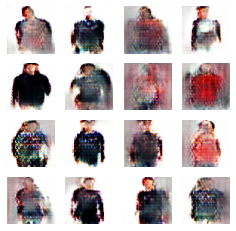

1012/1012 [==============================] - 59s 58ms/step - d_loss: 0.5914 - g_loss: 0.8885
Epoch 3/10
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.5288 - g_loss: 1.1267

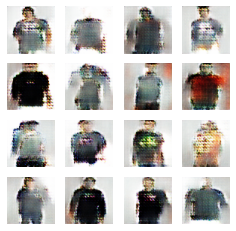

1012/1012 [==============================] - 59s 58ms/step - d_loss: 0.5288 - g_loss: 1.1274
Epoch 4/10
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.4877 - g_loss: 1.2955

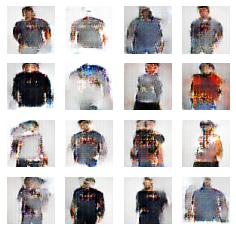

1012/1012 [==============================] - 59s 58ms/step - d_loss: 0.4876 - g_loss: 1.2959
Epoch 5/10
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.4712 - g_loss: 1.3866

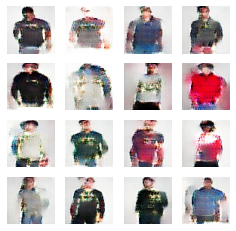

1012/1012 [==============================] - 59s 58ms/step - d_loss: 0.4710 - g_loss: 1.3868
Epoch 6/10
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.4530 - g_loss: 1.4815

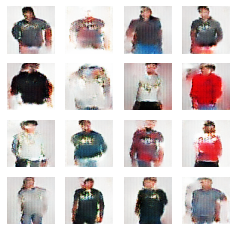

1012/1012 [==============================] - 59s 58ms/step - d_loss: 0.4530 - g_loss: 1.4815
Epoch 7/10
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.4296 - g_loss: 1.5892

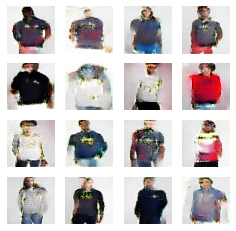

1012/1012 [==============================] - 59s 58ms/step - d_loss: 0.4296 - g_loss: 1.5896
Epoch 8/10
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.4064 - g_loss: 1.6927

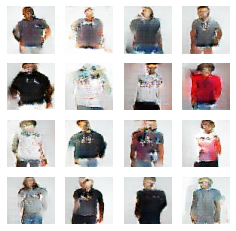

1012/1012 [==============================] - 59s 58ms/step - d_loss: 0.4063 - g_loss: 1.6926
Epoch 9/10
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.3966 - g_loss: 1.7487

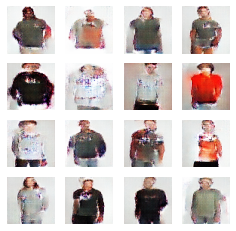

1012/1012 [==============================] - 60s 59ms/step - d_loss: 0.3963 - g_loss: 1.7499
Epoch 10/10
1011/1012 [============================>.] - ETA: 0s - d_loss: 0.3871 - g_loss: 1.7793

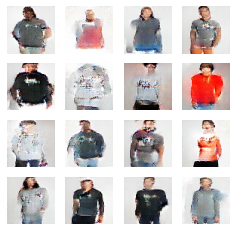

1012/1012 [==============================] - 59s 58ms/step - d_loss: 0.3871 - g_loss: 1.7784


In [86]:
# using good generator

generator = Sequential([
    Dense(8*8*512, use_bias = False, input_shape = (100,)),
    BatchNormalization(),
    LeakyReLU(),
    Reshape((8,8,512)),
    
    Conv2DTranspose(256 ,(4,4), strides = (2,2), use_bias = False, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(),
    
    Conv2DTranspose(128 ,(4,4), strides = (2,2), use_bias = False, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(),
    
    Conv2DTranspose(3 ,(4,4), strides = (2,2), use_bias = False, padding = 'same', activation = 'tanh'),
])

discriminator = Sequential([
    Conv2D(128, (5,5), strides = (2,2), padding = 'same', input_shape = (64,64,3)), # input_shape = (64,64,3)
    LeakyReLU(),
    Dropout(0.2),
    
    Conv2D(256, (5,5), strides = (2,2), padding = 'same'),
    LeakyReLU(),
    Dropout(0.2),
    
    Conv2D(512, (5,5), strides = (2,2), padding = 'same'),
    LeakyReLU(),
    Dropout(0.2),
    
    Flatten(),
    Dense(1, activation = 'sigmoid')
])
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)
D_LR = 0.0001 # UPDATED: discriminator learning rate
G_LR = 0.0005 # UPDATED: generator learning rate

dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=D_LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=G_LR, beta_1 = 0.5),  
    loss_fn=keras.losses.BinaryCrossentropy(),
)
NUM_EPOCHS = 10 # number of epochs
dcgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])